# Tuning the kinetic parameters for asphaltene precipitation and aggregation

This code calculates kp and kag coefficients to fit the differential equation system to experimental data. From the best calculated kp and kag, a0, a1 and c0 coefficients are calculated. These coefficients depend on Temperature and viscosity.

In the case of a Python script file (`*.py`), I will write a [module-level docstring][mod_docstring] (because you can't write markdown in a Python script).

<!--refs-->
[mod_docstring]: https://realpython.com/documenting-python-code/

In [483]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import sys

In [484]:
# read excel data
file_name = 'Ag_kinetics.xlsx'
df = pd.read_excel(file_name, sheet_name='Info', header=7, usecols='b:q')
df = df[df['sheet'].notna()]
display(df)

,Set,sheet,T (F),P (bar),Base,Solvent,S Amt (vol%),Precip,P Amt (vol%),Ceq (wtf Asp L1/T),visco_L1 (cP),dens_L1 (g/cc),SP_L1 (MPa^0.5),dens_Asp (g/cc),SP_Asp (MPa^0.5),Ca0 (kg/m3)
0,1,Set1,104.0,1.0,STL,Tol,75.0,C6,55.0,0.858282,0.485850,0.748791,15.670999,NaN,22.889265,14.752502
1,2,Set2,104.0,1.0,STL,Tol,75.0,C7,60.0,0.833403,0.537347,0.762251,15.816842,NaN,22.889265,13.570000
2,3,Set3,104.0,1.0,STL,Tol,75.0,C8,60.0,0.848633,0.614240,0.777780,15.970580,NaN,22.889265,13.846450
3,4,Set4,176.0,1.0,STL,Tol,75.0,C6,62.0,0.837227,0.362247,0.732269,15.038418,NaN,22.349547,12.466965
4,5,Set5,176.0,1.0,STL,Tol,75.0,C7,62.0,0.853216,0.419526,0.749536,15.227162,NaN,22.349547,12.760944
5,6,Set6,176.0,1.0,STL,Tol,75.0,C8,62.0,0.858430,0.550031,0.780260,15.563012,NaN,22.349547,13.284011


In [485]:
# pass raw data to numpy arrays
data = df.to_numpy()
ceq_set = data[:,9]
mu = data[:,10]
ca0 = data[:,15]
sheet_names = data[:,1]
T_set = data[:2]

In [486]:
t_exp = []
c_exp = []

# loop over the sheet names and store time and experimental data
# into t_exp and c_exp
for sheet_name in sheet_names:
    # read the relevant columns from the sheet into a DataFrame
    df = pd.read_excel(file_name, sheet_name=sheet_name, usecols='b:c')
    df = df.to_numpy()
    t_exp.append(df[:,0])
    c_exp.append(df[:,1])

In [487]:
# define functions
# NOTE: you don't need to write docstrings for every function (though you could), but write enough so that it is clear how to use your functions
def derivatives(t, y, kp, kag):
    '''
    arguments
    ---------
    t : float
        time [min]
    y : array[float]
        xyz
    kP : float
        precipitation kinetics [1/s]
    kAg : float
        aggregation kinetics [1/s]
    
    return
    ------
    '''
    cf, cag, c = y
    
    dcfdt = -kp*(cf - ceq)
    dcagdt = kag*c**2
    dcdt = kp*(cf - ceq) - kag*c**2
    
    return [dcfdt, dcagdt, dcdt]

# initial conditions
y0 = [1.0, 0.0, 0.0]

# Define a function that returns the model values for given parameters
def model(t, kp, kag):
    sol = solve_ivp(fun=lambda t, y: derivatives(t, y, kp, kag), t_span=t_span, y0=y0, t_eval=t)
    c_model = sol.y[0]
    return c_model

Use curve_fit to find the best coefficient values to fit experimental data

In [488]:
#define initial guesses
p0 = np.array([.001, .001])

#initialize best coeffiecient vector
kag_best = []
kp_best = []

#this for loop takes experimental data from each set including its respective ceq and time span.
#Coefficients are calculated using curve_fit
for i in range(len(t_exp)):
    t_ = t_exp[i]
    c_ = c_exp[i]
    ceq = ceq_set[i]
    # time span
    t_span = (0.0, t_exp[i][-1])
    # Use curve_fit to find the best values for kp and kag
    popt, pcov = curve_fit(model, t_, c_, p0=p0, method='trf')
    kag_best.append(popt[0])
    kp_best.append(popt[1])

# Print the best values
print(f"Best kp: {kp_best}")
print(f"Best kag: {kag_best}")

Best kp: [0.0685089763327784, 0.07836451029479373, 0.9489825308687698, 0.06411125478835496, 0.05511364198445039, 0.02624017398957867]
Best kag: [1.5023463741710446, 1.8665432485332636, 11.31032824153077, 2.2225162295462457, 1.233378734172117, 0.8060831177602883]


R2 Score: 86.58991252398111 %


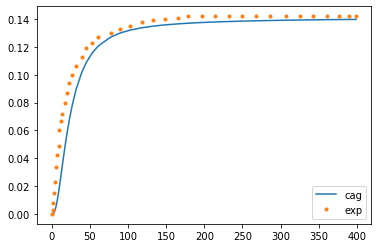

R2 Score: 49.85223307482135 %


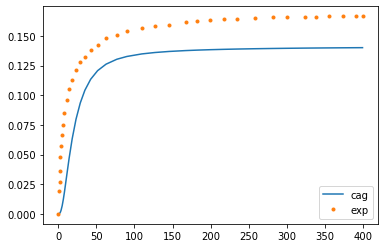

R2 Score: 27.286920678861893 %


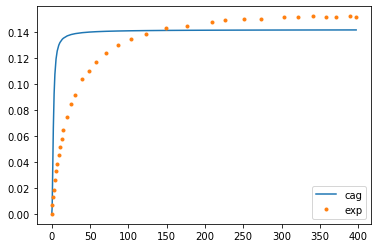

R2 Score: 79.38256991652557 %


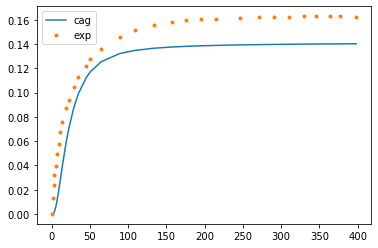

R2 Score: 95.001174984558 %


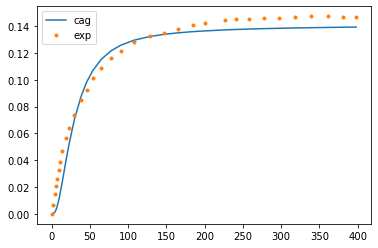

R2 Score: 93.26140266235241 %


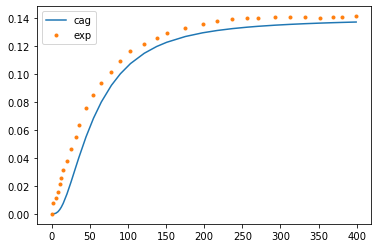

In [489]:
for i in range(len(t_exp)):
    
    t_span = (0.0, t_exp[i][-1])
    sol_best = solve_ivp(fun=lambda t, y: derivatives(t, y, kp_best[i], kag_best[i]), t_span=t_span, y0=y0, t_eval=t_exp[i])
    
    print('R2 Score:',r2_score(c_exp[i],sol_best.y[1])*100,'%')
    plt.plot(sol_best.t, sol_best.y[1], label='cag')
    plt.plot(t_exp[i], c_exp[i], label = 'exp', marker ='.', linestyle='None')
    plt.legend()
    plt.show()

Calculating a0, a1 and c0, from the obtained best kp and kag. The coefficients depend on T and mu.

In [490]:
# Define the functions for kp and kag
def kp(T, a0, a1):
    return a0 / np.exp(a1 / T)

def kag(T, mu, ca0, c0):
    R = 8.314 # J/mol.K, gas constant
    return ca0 * ((R * T) / (mu * 1000)) * c0

# Define the function to fit
def fit_func(data, a0, a1, c0):
    T, mu = data
    k = np.concatenate((kp(T, a0, a1), kag(T, mu, ca0, c0)))
    return k

# Define the data as a tuple
data = (T, mu)

# Perform the fit
p0 = np.array([.1, .1, .1]) # initial guesses for a0, a1, and c0
popt, pcov = curve_fit(fit_func, data, np.concatenate((kp_best, kag_best)), p0=p0)

# Extract parameters
a0, a1, c0 = popt

# Print the results
print(f"a0 = {a0:.4f}")
print(f"a1 = {a1:.4f}")
print(f"c0 = {c0:.4f}")

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

error: Result from function call is not a proper array of floats.

Using these coefficients solve the differential equations to obtain a new approximation

In [ ]:
# define functions
# NOTE: you don't need to write docstrings for every function (though you could), but write enough so that it is clear how to use your functions
set = 2
def derivatives_a0a1c0(t, y, a0, a1, c0):
    R = 8.314
    cf, cag, c = y
    
    dcfdt = -(a0/np.exp(a1/T[set]))*(cf - ceq)
    dcagdt = (ca0[set]*(.00089)*((R*T[set])/(mu[set]))*c0)*c**2
    dcdt = (a0/np.exp(a1/T[set]))*(cf - ceq) - (ca0[set]*(.00089)*((R*T[set])/(mu[set]))*c0)*c**2
    
    return [dcfdt, dcagdt, dcdt]

# time span
t_span = (0.0, t_exp[-1])

# initial conditions
y0 = [1.0, 0.0, 0.0]

# Define a function that returns the model values for given parameters
def model(t, a0, a1, c0):
    sol = solve_ivp(fun=lambda t, y: derivatives_a0a1c0(t, y, a0, a1, c0), t_span=t_span, y0=y0, t_eval=t_exp)
    c_model = sol.y[0]
    return c_model

Plot the new function given by coefficients a0, a1 and c0

In [ ]:
# Plot the model predictions using the best coefficients
sol_best = solve_ivp(fun=lambda t, y: derivatives_a0a1c0(t, y, a0, a1, c0), t_span=t_span, y0=y0, t_eval=t_exp)
plt.plot(t_exp, c_exp, label='exp')
#plt.plot(sol_best.t, sol_best.y[0], label='cf')
plt.plot(sol_best.t, sol_best.y[1], label='cag')
#plt.plot(sol_best.t, sol_best.y[2], label='c')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

#Show R2
print('R2 Score:',r2_score(c_exp,sol_best.y[1])*100,'%')

TypeError: only size-1 arrays can be converted to Python scalars